# This practice will cover learning points in Topic 2
### 1 - Fit MLR model in python with sklearn and statsmodels packages
### 2 - Model Selection
### 3 - Weighted regression
### 4 - Regularization, L1 and L2

Import required Python packages.

In [1]:
# if you haven't installed statsmodels
! pip install statsmodels dmba

In [7]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

%matplotlib inline

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [9]:
# DATA = Path('.').resolve().parents[1] / 'Practice/mlr'
# HOUSE_CSV = DATA / 'house_sales.csv'

HOUSE_CSV = 'house_sales.csv'

#### Data read and train-test split

In [10]:
houseall = pd.read_csv(HOUSE_CSV, sep='\t')

house, house_test = train_test_split(houseall, test_size=0.2)

print(house.shape, house_test.shape)

(18149, 22) (4538, 22)


In [5]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
26442,2007-04-13,1820000,9533600015,Single Family,2007-04-01,430900,0.990119,1838162.0,1,10193,...,3.5,4,10,2006,0,0,703000,807000,98004,False
23971,2012-11-14,675346,8682310220,Single Family,2012-11-01,335900,0.771829,874994.0,1,6750,...,2.5,2,8,2012,0,0,236000,435000,98053,True
14710,2007-08-09,490000,4318200280,Single Family,2007-08-01,434600,0.998621,490676.0,1,10136,...,1.0,3,7,1946,0,0,199000,163000,98136,False
2037,2007-02-23,530000,826000110,Single Family,2007-02-01,427800,0.982996,539168.0,1,2509,...,1.0,2,7,1950,0,0,143000,263000,98136,False
18752,2006-05-22,480000,6884800350,Single Family,2006-05-01,400600,0.920496,521458.0,1,4275,...,1.0,2,7,1925,0,0,233000,252000,98115,False


In [11]:
# let's see more columns
pd.set_option('display.max_columns', 200)

In [12]:
house_test.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,SqFtTotLiving,SqFtFinBasement,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1333,2006-10-05,540000,514500175,Single Family,2006-10-01,418300,0.961167,561817.0,1,7200,2760,1380,1.75,6,7,1957,0,0,380000,228000,98005,False
11699,2006-04-26,197500,3530500010,Single Family,2006-04-01,396500,0.911075,216777.0,1,2332,920,0,1.00,2,8,1980,0,0,63000,98000,98198,False
18977,2007-03-26,339950,7128300320,Single Family,2007-03-01,429600,0.987132,344381.0,1,4500,820,0,1.00,3,7,1902,0,1,185000,205000,98144,False
2912,2008-09-23,415000,1125049052,Multiplex,2008-09-01,394900,0.907399,457351.0,3,6480,1700,0,3.00,5,6,1951,0,1,286000,253000,98115,False
3043,2006-07-15,406000,1172000135,Single Family,2006-07-01,407700,0.936811,433385.0,1,6350,1940,970,2.00,4,7,1951,0,0,161000,252000,98103,False


We can use the `LinearRegression` model from _scikit-learn_.

## 1.1 - Multiple Linear Regression (SKlearn)

In [12]:
print(house.columns)

Index(['DocumentDate', 'SalePrice', 'PropertyID', 'PropertyType', 'ym',
       'zhvi_px', 'zhvi_idx', 'AdjSalePrice', 'NbrLivingUnits', 'SqFtLot',
       'SqFtTotLiving', 'SqFtFinBasement', 'Bathrooms', 'Bedrooms',
       'BldgGrade', 'YrBuilt', 'YrRenovated', 'TrafficNoise', 'LandVal',
       'ImpsVal', 'ZipCode', 'NewConstruction'],
      dtype='object')


In [14]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
house[subset].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
14499,243128.0,1000,5200,1.00,3,6
23755,777054.0,2680,7220,3.50,3,9
18195,251803.0,1200,5250,2.00,3,6
4330,472131.0,3120,45913,2.75,4,9
23333,604444.0,3100,10189,2.50,5,8


In [14]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -511325.143
Coefficients:
 SqFtTotLiving: 228.67639967262733
 SqFtLot: -0.1370674484066895
 Bathrooms: -24265.616030771384
 Bedrooms: -46713.96975482197
 BldgGrade: 105852.42400327271


### Assessing the Model with performance metricss
_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score` and `RMSE`.

In [19]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print('Training data:')
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

fitted_test = house_lm.predict(house_test[predictors])
RMSE_test = np.sqrt(mean_squared_error(house_test[outcome], fitted_test))
r2_test = r2_score(house_test[outcome], fitted_test)
print('Validation data:')
print(f'RMSE_test: {RMSE_test:.0f}')
print(f'r2_test: {r2_test:.4f}')

Training data:
RMSE: 255506
r2: 0.5449
Validation data:
RMSE_test: 283098
r2_test: 0.5252


## 1.2 - Multiple Linear Regression (statsmodels)

While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [20]:
mlr_sm = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = mlr_sm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     4345.
Date:                Sat, 28 Jan 2023   Prob (F-statistic):               0.00
Time:                        02:16:59   Log-Likelihood:            -2.5173e+05
No. Observations:               18149   AIC:                         5.035e+05
Df Residuals:                   18143   BIC:                         5.035e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.6764      4.295     53.240

### 1.3 Correlations between predictors

Correlation Matrix 
                SqFtTotLiving   SqFtLot  Bathrooms  Bedrooms  BldgGrade
SqFtTotLiving       1.000000  0.189457   0.763314  0.598110   0.772256
SqFtLot             0.189457  1.000000   0.101955  0.065277   0.144748
Bathrooms           0.763314  0.101955   1.000000  0.534299   0.658474
Bedrooms            0.598110  0.065277   0.534299  1.000000   0.365658
BldgGrade           0.772256  0.144748   0.658474  0.365658   1.000000


[Text(0.5, 0, 'SqFtTotLiving'),
 Text(1.5, 0, 'SqFtLot'),
 Text(2.5, 0, 'Bathrooms'),
 Text(3.5, 0, 'Bedrooms'),
 Text(4.5, 0, 'BldgGrade')]

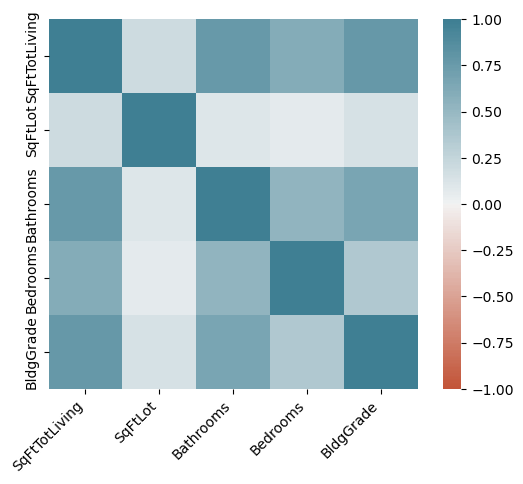

In [21]:
corr = house[predictors].corr()
print("Correlation Matrix \n {}".format(corr))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## 2 - Model Selection and Stepwise Regression

In [25]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
house[predictors].head()

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,PropertyType,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction
2957,2230,5543,2.50,4,7,Single Family,1,580,2005,0,False
5233,2790,10819,2.75,4,9,Single Family,1,0,1996,0,False
3390,1900,46609,2.50,4,7,Single Family,1,720,1974,0,False
13107,2440,8000,2.75,5,7,Single Family,1,1200,1972,0,False
22926,1620,5289,2.00,3,6,Single Family,1,810,1945,0,False


In [31]:
print("\n Predictors before nominal varibale(s) treatment: {} \n".format(house[predictors].shape))
print("PropertyType List: \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X = pd.get_dummies(house[predictors], drop_first=True) # why drop_first?
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

print("\n Predictors after nominal varibale(s) treatment: {} \n".format(X.shape))

# fit model
house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())


 Predictors before nominal varibale(s) treatment: (18149, 11) 

PropertyType List: 
Single Family    16594
Townhouse         1349
Multiplex          206
Name: PropertyType, dtype: int64

 Predictors after nominal varibale(s) treatment: (18149, 12) 

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     2244.
Date:                Sat, 28 Jan 2023   Prob (F-statistic):               0.00
Time:                        02:23:58   Log-Likelihood:            -2.5061e+05
No. Observations:               18149   AIC:                         5.012e+05
Df Residuals:                   18136   BIC:                         5.013e+05
Df Model:                          12                                         
Covariance Type:            nonrobust 

We can use the `stepwise_selection` method from the _dmba_ package.

In [1]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

NameError: name 'house' is not defined

## 3 - Weighted regression
For the house data recent sale price is more relavent for future prediction, old sale data is less reliable, therefore, we like to emphasis the recent sale data by apply more weight. We will use year the house sale to 2005 as weight.

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [34]:
print("\nDocumentDate List \n{}".format(house['DocumentDate'].value_counts(dropna=False)))


DocumentDate List 
2006-07-26    52
2006-08-21    46
2006-04-25    45
2006-05-30    44
2006-08-24    44
              ..
2013-01-22     1
2014-02-21     1
2010-10-02     1
2014-01-03     1
2011-12-30     1
Name: DocumentDate, Length: 2466, dtype: int64


In [42]:
house['Year'] = pd.to_datetime(house['DocumentDate']).dt.year
house['Weight'] = house['Year'] - (house['Year'].min()-1)

In [44]:
# other ways to parse yewr
# house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]  #list comprehension
# house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))  # apply()

In [45]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house['Weight'])
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

/var/folders/tn/0z9twpqx19g80xjvqb4w0_jw0000gn/T/ipykernel_73372/678231476.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd.DataFrame({


,predictor,house_lm,house_wt
0,SqFtTotLiving,228.676400,244.341366
1,SqFtLot,-0.137067,-0.370270
2,Bathrooms,-24265.616031,-31660.067343
3,Bedrooms,-46713.969755,-52171.544134
4,BldgGrade,105852.424003,114701.548557
5,intercept,-511325.143087,-570889.909700


       abs_residual_lm  abs_residual_wt  Year
2957      48153.512243     43856.424349  2007
5233       3382.427799     15712.124016  2013
3390     260207.511485    279250.744085  2006
13107     59299.592309     68186.203658  2008
22926     53695.922658     67183.731237  2007


Year   Abs_residual_lm    Abs_residual_wt
2006 138179.10874150335 143601.61205456185
2007 147332.9541605233 151886.90347053696
2008 141432.17758821006 145456.6801747045
2009 143608.10993789474 147193.50389159613
2010 166737.3956289376 169606.79835510827
2011 161883.6420742616 164837.92285076942
2012 174659.59036774436 176464.07894653897
2013 197154.31319727775 199072.3164480179
2014 183417.16555352183 185250.8351378108
2015 178003.13599836404 175179.82927318604


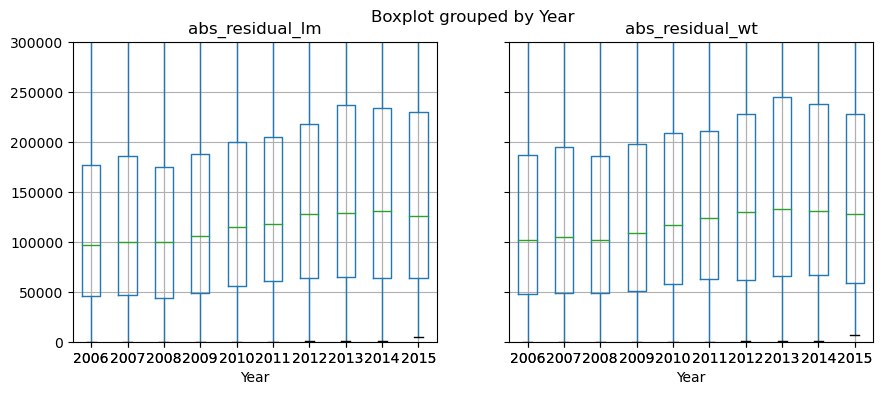

In [46]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

print("\n\nYear   Abs_residual_lm    Abs_residual_wt")
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

Seems only help 2015 prediction reduce the residuals. 

If we have a recent holdout sample we can test the weight could help for future prediction or not

# 4 - Regularization

In [15]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

outcome = 'AdjSalePrice'

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X_train = pd.get_dummies(house[predictors], drop_first=True)
X_train['NewConstruction'] = [1 if nc else 0 for nc in X_train['NewConstruction']]
y_train = house[outcome]

X_test = pd.get_dummies(house_test[predictors], drop_first=True)
X_test['NewConstruction'] = [1 if nc else 0 for nc in X_test['NewConstruction']]
y_test = house_test[outcome]

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
14499           1000     5200       1.00         3          6  Single Family   
23755           2680     7220       3.50         3          9  Single Family   
18195           1200     5250       2.00         3          6  Single Family   
4330            3120    45913       2.75         4          9  Single Family   
23333           3100    10189       2.50         5          8  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
14499               1                0     1969            0            False  
23755               1                0     2003            0            False  
18195               1                0     1906            0            False  
4330                1                0     1987            0            False  
23333               1                0     2002            0            False  

 PropertyType List 
Single Family    1

### Regular Multiple Regression

In [22]:
house_lm = LinearRegression()
house_lm.fit(X_train, y_train)

mlr_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((house_lm.intercept_, house_lm.coef_), 
                                axis=None), 3))
)

mlr_coefs

{'Intercept': 6050357.643,
 'SqFtTotLiving': 203.618,
 'SqFtLot': 0.026,
 'Bathrooms': 36980.243,
 'Bedrooms': -52950.588,
 'BldgGrade': 138659.289,
 'NbrLivingUnits': 17741.105,
 'SqFtFinBasement': 10.045,
 'YrBuilt': -3528.013,
 'YrRenovated': -2.476,
 'NewConstruction': -7861.422,
 'PropertyType_Single Family': 54212.279}

In [25]:
fitted_test = house_lm.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, fitted_test))
r2_test = r2_score(y_test, fitted_test)
fitted_train = house_lm.predict(X_train)
MSE_train = np.sqrt(mean_squared_error(y_train, fitted_train))
r2_train = r2_score(y_train, fitted_train)
print(f'regular mlr RMSE_test: {MSE_test:.0f}')
print(f'r2_test: {r2:.4f}')
print(f'regular mlr RMSE_train: {MSE_test:.0f}')
print(f'r2_train: {r2:.4f}')



regular mlr RMSE_test: 246913
r2_test: 0.5722
regular mlr RMSE_train: 246913
r2_train: 0.5722


### L2 - Ridge regression (Parameter shrinkage)

In [16]:
ridge_cv = RidgeCV(normalize=True, alphas=np.logspace(-10, 1, 400))
ridge_model = ridge_cv.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)
ridge_mae = np.mean(np.abs(y_test - ridge_prediction))
ridge_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((ridge_model.intercept_, ridge_model.coef_), 
                                axis=None), 3))
)

print('Ridge Regression MAE: {}'.format(np.round(ridge_mae, 3)))
print('Ridge Regression alpha:', ridge_cv.alpha_)
print('Ridge Regression coefficients:')
ridge_coefs

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


Ridge Regression MAE: 139491.895
Ridge Regression alpha: 0.00675420028560558
Ridge Regression coefficients:


{'Intercept': 5941979.982,
 'SqFtTotLiving': 199.152,
 'SqFtLot': 0.038,
 'Bathrooms': 38452.355,
 'Bedrooms': -51578.827,
 'BldgGrade': 138451.619,
 'NbrLivingUnits': 8868.065,
 'SqFtFinBasement': 12.907,
 'YrBuilt': -3458.761,
 'YrRenovated': -1.378,
 'NewConstruction': -7819.247,
 'PropertyType_Single Family': 37216.667}

In [26]:
ridge_prediction = ridge_model.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, ridge_prediction))
r2 = r2_score(y_test, ridge_prediction)
ridge_prediction_train = ridge_model.predict(X_train)
MSE_train = np.sqrt(mean_squared_error(y_train, ridge_prediction_train))
r2_train= r2_score(y_train, ridge_prediction_train)
print(f'Ridge Regression RMSE_test: {MSE_test:.0f}')
print(f'Ridge Regression r2_test: {r2:.4f}')
print(f'Ridge Regression RMSE_train: {MSE_train:.0f}')
print(f'Ridge Regression r2_train: {r2_train:.4f}')

Ridge Regression RMSE_test: 246774
Ridge Regression r2_test: 0.5722
Ridge Regression RMSE_train: 245082
Ridge Regression r2_train: 0.5997


### L1 - Lasso regression (Parameter sparsity)

In [17]:
lasso_cv = LassoCV(normalize=True, alphas=np.logspace(-10, 1, 400))
lasso_model = lasso_cv.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
lasso_mae = np.mean(np.abs(y_test - lasso_prediction))
lasso_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((lasso_model.intercept_, lasso_model.coef_), axis=None), 3))
)

print('LASSO MAE: {}'.format(np.round(lasso_mae, 3)))
print('LASSO alpha:', lasso_cv.alpha_)
print('LASSO coefficients:')
lasso_coefs

LASSO MAE: 139432.655
LASSO alpha: 7.2804024723085465
LASSO coefficients:


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


{'Intercept': 5927650.283,
 'SqFtTotLiving': 201.637,
 'SqFtLot': 0.001,
 'Bathrooms': 34056.674,
 'Bedrooms': -50486.457,
 'BldgGrade': 138528.758,
 'NbrLivingUnits': -2625.01,
 'SqFtFinBasement': 10.445,
 'YrBuilt': -3426.384,
 'YrRenovated': -0.0,
 'NewConstruction': -4284.639,
 'PropertyType_Single Family': 0.0}

In [27]:
lasso_prediction = lasso_model.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, lasso_prediction))
r2 = r2_score(y_test, lasso_prediction)
lasso_prediction_train = lasso_model.predict(X_train)
MSE_train = np.sqrt(mean_squared_error(y_train, lasso_prediction_train))
r2_train= r2_score(y_train, lasso_prediction_train)
print(f'Lasso Regression RMSE_test: {MSE_test:.0f}')
print(f'Lasso Regression r2_test: {r2:.4f}')
print(f'Lasso Regression RMSE_train: {MSE_train:.0f}')
print(f'Lasso Regression r2_train: {r2_train:.4f}')

Lasso Regression RMSE_test: 246785
Lasso Regression r2_test: 0.5722
Lasso Regression RMSE_train: 245118
Lasso Regression r2_train: 0.5996


# Home Work

1. Compare the three model fits and draw conclusion 
from the comparision of the three model fits regarding there coefficent difference

When comparing the ridge model and lasso model, the coefficients of lasso model are more shrinkaged to 0, such as the coefficients for 'SqFtLot',  'YrRenovated', and 'PropertyType_Single Family'. The absolute value for coefficients of  'NbrLivingUnits' and 'NewConstruction' are also smaller in lasso regression. 

When comparing coefficients of the regular multiple regression model and ridge model, I feel some coefficients have larger absolute value in ridge model, while some coefficients have smaller absolute value (so cannot say the ridge model shrinkage the coefficients). For example, 'Bathrooms','BldgGrade','SqFtFinBasement', and 'NewConstruction' have larger absolute value in coefficients, while coefficients of 'NbrLivingUnits', 'YrBuilt', 'YrRenovated' and  'PropertyType_Single Family' are smaller in absolute value. 

When comparing coefficients of the regular multiple regression model and lasso model, it is more likely than coefficients are shrinked, such as the coefficents for 'SqFtLot',  'Bathrooms',  'NbrLivingUnits',  'YrRenovated',  'NewConstruction' and  'PropertyType_Single Family'. 


2. Show the three model performance on both train and test

I calculated RMSE and R^2 for each model's train and test set, and printed the statistics at the end of each section for 3 models. 

regular mlr RMSE_test: 246913 
r2_test: 0.5722
regular mlr RMSE_train: 246913
r2_train: 0.5722

Ridge Regression RMSE_test: 246774
Ridge Regression r2_test: 0.5722
Ridge Regression RMSE_train: 245082
Ridge Regression r2_train: 0.5997

Lasso Regression RMSE_test: 246785
Lasso Regression r2_test: 0.5722
Lasso Regression RMSE_train: 245118
Lasso Regression r2_train: 0.5996